# Video Classification (Humpback Whales) - Keras CNN + RNN 

Source: https://keras.io/examples/vision/video_classification/


Description: Following the tutorial above to try and configure cnn + rnn combined architecture to classify youtube videos as containing a humpback whale encounter (True / relevant) or not (False / irrelevant)

Note: Input video size = 40 frames (adjust as needed; ref to data_preprocessing_humpback_whales.ipynb for justification of why 40 frames)

# Setup

In [2]:
# !pip install -q git+https://github.com/tensorflow/docs

In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

from sklearn import metrics
import seaborn as sns

# Define Hyperparameters

In [17]:
#need to find out what each hyperparameter is for
# [TO DO]
ROOT_DIR = os.path.dirname(os.path.abspath('video_classification_cnn_rnn.ipynb'))

IMG_SIZE = 224
BATCH_SIZE = 64 
EPOCHS = 10

MAX_SEQ_LENGTH = 40 #20 in tutorial, but changed to 40 since I want to get 40 max frames per video (even if multiple clips)
NUM_FEATURES = 2048 #the number of features we extract from frames using InceptionV3 (kepts same as tutorial)

# Data Preparation

In [3]:
#load in datasets
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

X_valid = pd.read_csv('data/X_valid.csv')
y_valid = pd.read_csv('data/y_valid.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

for df in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    df.set_index('Unnamed: 0', inplace=True)
    df.index.name = 'index'

print(f"Total videos for training: {len(X_train)}")
print(f"Total videos for validation: {len(X_valid)}")
print(f"Total videos for testing: {len(X_test)}")

X_train.head(3)

Total videos for training: 325
Total videos for validation: 41
Total videos for testing: 41


,title,url,duration_seconds,views,renamed_title,duration_mins,num_frames,occurence_intervals,double_checked,rand_sampled_intervals
index,,,,,,,,,,
72,Snorkelling with Humpback Whales & Whale Shark...,https://youtu.be/MLN1f1rBE3Q,234,851,video_0072.mp4,3.900000,7008,"[('1:50', '1:57'), ('2:15', '2:30')]",False,NaN
128,Top 10 INDIANS MOST POWERFUL WEAPONS 2019,https://youtu.be/fBosTF8xJB8,390,16,video_0132.mp4,6.500000,9750,NaN,True,"[171 sec, 186 sec]"
299,Humpback Whale Amongst Sea Lions on Monterey B...,https://youtu.be/3nOe6Fx7tjo,86,31141,video_0702.mp4,1.433333,2577,"[('0:19', '0:34')]",True,NaN


Figuring out how to feed videos into the network:
since the number of frames can vary from video to video, we will:
 1. Capture the frames of a video 
 2. Extract frames from the videos until a max frame count is reached
 3. In the case where a video's frame count is lesser than the maximum frame count, we will pad the video with zeros

The process above is directly from the tutorial. however, since we already have the frames extracted + downloaded, we will:
 1. Load in our frames
 2. Only get up to 40 frames per video
 3. In the case where a video's frame count is lesser than the maximum frame count, we will pad the video with zeros

In [4]:
## Get frames from a video in array format
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    ''' returns array representation of image frames from video passed in'''
    
    ii=0 
    next_frame = 0
    cap = cv2.VideoCapture(path)
    frames = []
    
    # print(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  #opencv fives BGR [0,1,2] channel order; this line of code reorders our color channels to RGB [2,1,0]
            frames.append(frame)
            
            #uncomment to save frames (note: will have to configure filename so it takes on the respective video name)
            # file_name = "video_0000_clip_1_frame_" + str(ii) + ".jpg"
            # frame_path = os.path.join('opencv_trial/', file_name)
            # cv2.imwrite(frame_path, frame)
            # ii += 1

            if len(frames) == max_frames:
                break

            #to skip over some redundant frames and get more diverse set of frames over span of our video
            #while still getting a fixed, uniform number of max_frames for each video
            next_frame += (cap.get(cv2.CAP_PROP_FRAME_COUNT) / max_frames)
            cap.set(1, next_frame)

    finally:
        cap.release()

    return np.array(frames)


## use a pre-trained network to extract meaningful features from the extracted frames
## Here, we use InceptionV3 (same as tutorial), which is pre-trained on the ImageNet-1k dataset
def build_feature_extractor():
    '''Extracts meaningful features from frames using InceptionV3, which is pre-trained on ImageNet-1k dataset'''

    #instantiate InceptionV3 as feature extractor (don't include top layer bc we're not using this for classification - just feature extraction)
    feature_extractor = keras.applications.InceptionV3(
                                                        weights      = 'imagenet',
                                                        include_top  = False,
                                                        pooling      = 'avg',
                                                        input_shape  = (IMG_SIZE, IMG_SIZE, 3)
                                                    )


    #required preprocessing for inceptionV3 - scales input pixels between -1 and 1
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")



### Testing out load_video()

In [65]:
## trying out load_video on an example_vid (this function gets 40 (max_frames) frames per video)
## NOTE: when dealing with multiple clips from one video, will have to set max_frames = 40/num_clips_from_video

# example_vid = 'relevant_video_clips/video_0000_clip_1.mp4'
# frames = load_video(example_vid, max_frames=40)

# print(frames.shape) #(40, 224, 224, 3) --> 40 frames from example_vid of dimensions 224 x 224 x 3 (l x w x rgb)
# # frames

(40, 224, 224, 3)


### Feature Extractor

In [5]:
## using feature_extractor to extract meaningful features from frames
feature_extractor = build_feature_extractor()
feature_extractor

2022-02-23 12:57:19.416406: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Encode labels (relevant) to numerical form before feeding them to the model

Note: tutorial uses keras.layers.StringLookup, but since we already have True/False labels, and our problem
is essentially binary classification (relevant/not relevant), we just encode True as 1 (relevant) and False as 0 (not relevant).

In [6]:
# encode relevant true/false labels as integers
# true as 1, false as 0
def label_processor(labels_column):
    return labels_column.astype(int)

In [ ]:
# y_train['relevant'] = y_train['relevant'].astype('bool')
# y_train

# y_train['relevant'] = label_processor(y_train['relevant'])
# y_train['relevant'].values

# labels = y_train["relevant"].values
# labels = label_processor(labels[..., None]) #.numpy() #labels[..., None] makes it an array of shape (325, 1) (vertical array)
# labels.shape 

### Putting all the pieces together (load_video, preprocessing input, converting labels to int) to create our data processing utility

In [7]:
import glob

def prepare_all_videos(X, y, clip_folder, root_dir):
    num_samples = len(X)
    video_names = X["renamed_title"].values.tolist()
    labels      = y['relevant'].values 
    labels      = label_processor(labels[..., None])

    # `frame masks` and `frame_features are what we will feed to our sequence model
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is masked 
    #  with padding or not
    frame_masks    = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros( shape = (num_samples, MAX_SEQ_LENGTH, NUM_FEATURES) , dtype="float32")

    #for each video
    for index, video_name in enumerate(video_names):
        
        #Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
        video_name = video_name.split('.mp4')[0]
        frames     = get_frames_for_all_clips(video_name, clip_folder, root_dir)

        #initialize placeholders to store the masks and features of the current video
        temp_frame_mask     = np.zeros(shape=(1, MAX_SEQ_LENGTH ), dtype="bool")  
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        #extract features from the frames of the current video
        for i, batch in enumerate(frames):
            
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            
            temp_frame_mask[i, :length] = 1 # 1 = not masked, 0 = masked

        frame_features[index, ] = temp_frame_features.squeeze()
        frame_masks[index, ]    = temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels


def get_frames_for_all_clips(video, clip_folder, root_dir):

    '''
    gets the frames across all clips belonging to a video
    
    first:      find all clips belonging to video
    then:       get MAX_SEQ_LENGTH/n_clips frames from each clip (put them all in same frames array)
    finally:    add batch dimension 
    '''

    # find all clips from the same video
    video_clips = sorted([clip for clip in glob.glob(clip_folder + video + '*.mp4')])

    #get frames for each clip belonging to video and append to frames array
    #set max_frames_per_clip so we get MAX_SEQ_LENGTH (40) total frames for each video
    max_frames_per_clip = MAX_SEQ_LENGTH / len(video_clips)
    frames              = load_video(os.path.join(root_dir, video_clips[0]), max_frames = max_frames_per_clip)
    
    for clip_path in video_clips[1:]:
        clip_frames = load_video(os.path.join(root_dir, clip_path), max_frames = max_frames_per_clip)
        frames      = np.concatenate((frames, clip_frames))
    
    # add batch dimension
    return frames[None, ...]


In [8]:
# prepare_all_videos(X_train[0:2], y_train, 'video_clips/', ROOT_DIR)

train_data, train_labels = prepare_all_videos(X_train, y_train, 'video_clips/', ROOT_DIR)
# valid_data, valid_labels = prepare_all_videos(X_valid, y_valid, 'video_clips/', ROOT_DIR)
# test_data, test_labels   = prepare_all_videos(X_test, y_test, 'video_clips/', ROOT_DIR)


[h264 @ 0x7f87335c9000] mmco: unref short failure
[h264 @ 0x7f87335c9000] mmco: unref short failure
[h264 @ 0x7f87335c9000] mmco: unref short failure
[h264 @ 0x7f87335c9000] mmco: unref short failure
[h264 @ 0x7f87335c9000] mmco: unref short failure
[h264 @ 0x7f87335c9000] mmco: unref short failure
[h264 @ 0x7f872a2ad600] mmco: unref short failure
[h264 @ 0x7f872a2ad600] mmco: unref short failure
[h264 @ 0x7f872a2ad600] mmco: unref short failure
[h264 @ 0x7f872a2ad600] mmco: unref short failure
[h264 @ 0x7f8732cffa00] mmco: unref short failure
[h264 @ 0x7f8732cffa00] mmco: unref short failure
[h264 @ 0x7f872d44b800] mmco: unref short failure
[h264 @ 0x7f872d44b800] mmco: unref short failure
[h264 @ 0x7f872d44b800] mmco: unref short failure
[h264 @ 0x7f872d44b800] mmco: unref short failure
[h264 @ 0x7f872d44b800] mmco: unref short failure
[h264 @ 0x7f872d44b800] mmco: unref short failure
[h264 @ 0x7f8732d94e00] mmco: unref short failure
[h264 @ 0x7f8732d94e00] mmco: unref short failure


KeyboardInterrupt: 

In [14]:
#note: above cell was only able to load train_data, train_labels (was taking too long and was getting mmco: unref short failure message)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

train_data

Frame features in train set: (325, 40, 2048)
Frame masks in train set: (325, 40)


(array([[[3.91587704e-01, 1.20912798e-01, 1.02832878e+00, ...,
          1.13680458e+00, 6.93469405e-01, 3.87498662e-02],
         [4.67893302e-01, 2.02209055e-01, 6.92285180e-01, ...,
          1.20595193e+00, 6.74743354e-01, 9.25345197e-02],
         [1.31781495e+00, 2.78069586e-01, 4.37233061e-01, ...,
          5.10836303e-01, 3.03572088e-01, 7.24800050e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[2.01902658e-01, 4.29305434e-01, 3.00976783e-01, ...,
          0.00000000e+00, 2.29416236e-01, 4.50091094e-01],
         [7.55701289e-02, 2.69047290e-01, 1.36227414e-01, ...,
          2.32419949e-02, 1.64669305e-01, 2.39399046e-01],
       

In [15]:
test_data, test_labels   = prepare_all_videos(X_test, y_test, 'video_clips/', ROOT_DIR)

[h264 @ 0x7f87336b9600] mmco: unref short failure
[h264 @ 0x7f872d334e00] mmco: unref short failure
[h264 @ 0x7f872d334e00] mmco: unref short failure
[h264 @ 0x7f872d334e00] mmco: unref short failure
[h264 @ 0x7f872d334e00] mmco: unref short failure
[h264 @ 0x7f872d334e00] mmco: unref short failure
[h264 @ 0x7f872d334e00] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure
[h264 @ 0x7f872dc83400] mmco: unref short failure


In [16]:
print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in test set: (41, 40, 2048)
Frame masks in test set: (41, 40)


# The Sequence Model

Now, we can feed this data to a sequence model consisting of recurrent layers like GRU


In [21]:
#utility for our sequence model
def get_sequence_model():
    class_vocab = [0, 1] #label_processor.get_vocabulary() #will need to modify bc for our use case, we have class labels [1,0] based on relevancy status

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return rnn_model

#utility for running experiments
def run_experiment():
    filepath = "tmp/video_classifier/"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

    seq_model = get_sequence_model()
    history   = seq_model.fit([train_data[0], train_data[1]], 
                               train_labels,
                               validation_split = 0.10,
                               epochs = EPOCHS,
                               callbacks = [checkpoint],
                            )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)

    #printing metrics
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


In [22]:
# _, sequence_model = run_experiment()
history, sequence_model = run_experiment()


Epoch 1/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.7077 - accuracy: 0.5312
Epoch 1: val_loss improved from inf to 0.64582, saving model to /tmp/video_classifier
10/10 [==============================] - 9s 278ms/step - loss: 0.7074 - accuracy: 0.5308 - val_loss: 0.6458 - val_accuracy: 0.7273
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6918
Epoch 2: val_loss improved from 0.64582 to 0.57486, saving model to /tmp/video_classifier
10/10 [==============================] - 0s 49ms/step - loss: 0.6156 - accuracy: 0.6918 - val_loss: 0.5749 - val_accuracy: 0.7273
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.5241 - accuracy: 0.8090
Epoch 3: val_loss improved from 0.57486 to 0.57363, saving model to /tmp/video_classifier
10/10 [==============================] - 0s 48ms/step - loss: 0.5241 - accuracy: 0.8082 - val_loss: 0.5736 - val_accuracy: 0.7273
Epoch 4/10
 9/10 [==========================>...] - ETA: 0s -

In [120]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
sequence_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40, 2048)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 40, 16)       99168       ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 gru_3 (GRU)                    (None, 8)            624         ['gru_2[0][0]']            

# Inference

In [305]:
def prepare_single_video(frames):
    # frames = frames[None,...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i,j,:] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1 #1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path, video_folder = "video_clips/", silent=False):
    class_vocab = [0, 1] #label_processor.get_vocabulary()

    # the original form of getting frames (if you use this, uncomment frames=frames[None,...] in prepare_single_video)
    # frames = load_video(os.path.join(video_folder, path), max_frames = 40) #or video_clips? 

    # Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
    path   = path.split('.mp4')[0]
    frames = get_frames_for_all_clips(path, "video_clips/", ROOT_DIR)
    
    frame_features, frame_mask = prepare_single_video(frames)
    
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    if silent == False:
        for i in np.argsort(probabilities)[::-1]:
            print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    return frames, probabilities

# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images, video_name, saveto_path):
    
    converted_images = images.astype(np.uint8)
    imageio.mimsave(f"{saveto_path}{video_name}.gif", converted_images, fps=10)
    return embed.embed_file(f"{saveto_path}{video_name}.gif")


### Testing out how to display single gif

Test video path: video_0074_clip_1.mp4
  1: 75.48%
  0: 24.52%
shape:  (35, 224, 224, 3)



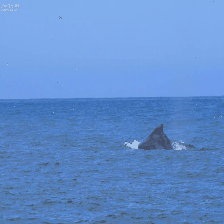

In [266]:
test_video = "video_0074_clip_1.mp4" #np.random.choice(X_test["renamed_title"].values.tolist())
print(f"Test video path: {test_video}")

test_frames, prob = sequence_prediction(test_video)
print('shape: ', test_frames.shape)

to_gif(test_frames[:MAX_SEQ_LENGTH])

## Running Our Model on Our Entire Test Set + Getting DF with video_name, true label, pred labels

In [82]:
#frame features: test_data[0]
#frame masks   : test_data[1]

#returns a list of probability distributions of each class [0,1] being correct for each of our items in our test set
#https://datascience.stackexchange.com/questions/69664/how-to-interpret-keras-predict-output 

##important: the probabilities returned are randomized with regard to their order
##if we want to preserve order + store true/pred for each video, we will have to pass in 1 by 1 (which is why we make `test_classifications` in next cell)
##so we don't really use the following two lines:

# predicted = sequence_model.predict([test_data[0], test_data[1]])
# print('shape: ', predicted.shape)


shape:  (41, 2)


### Specify Model Version (For Saving Figures Purposes)

In [233]:
model_version = 'v1'

### Get Test Classifications

In [279]:
# I think order is not maintained in predictions generated by model, so to truly make sure a prediction belongs to a video, we will feed in each video in our test set individually 
# and get pred to create df containing video name, true label, and pred label

# note: when we run our model on the videos in the test set, we're feeding in its clips rather than the entire video for consistency with the test evaluation done in
# `run_experiment()`

test_classifications = pd.DataFrame({'video': list(X_test['renamed_title']),
                                     'true': list(y_test['relevant'].astype("int")),
                                     'pred': [None for i in range(0, len(X_test))]
                                    })

probs = []
for index, row in test_classifications.iterrows():
  video = row['video']

  #get + display the prediction probabilities
  frames, probabilities = sequence_prediction(path = video, silent=True)

  probs.append(probabilities)
  test_classifications.at[index, 'pred'] = np.argmax(probabilities)


#save as csv 
test_classifications.to_csv(f"model_figures/test_classifications_model_{model_version}.csv")

test_classifications.head()

,video,true,pred
0,video_0074.mp4,1,1
1,video_0555.mp4,0,0
2,video_0126.mp4,0,0
3,video_0759.mp4,0,0
4,video_0115.mp4,0,1


In [231]:
#finding which videos were incorrectly classified (pred labeled != true label)
incorrect_classifications = test_classifications[test_classifications.true != test_classifications.pred].copy(deep=True)
incorrect_classifications


,video,true,pred
4,video_0115.mp4,0,1
10,video_0101.mp4,1,0
18,video_0034.mp4,1,0
21,video_0695.mp4,1,0
24,video_0810.mp4,0,1
30,video_0776.mp4,0,1
31,video_0629.mp4,1,0
37,video_0762.mp4,0,1
38,video_0618.mp4,0,1
39,video_0513.mp4,0,1


In [232]:
#put true and pred labels in variables for easy use later on
y_true = list(test_classifications['true'])
y_pred = list(test_classifications['pred'])

### Plotting Model Accuracy + Loss Curves

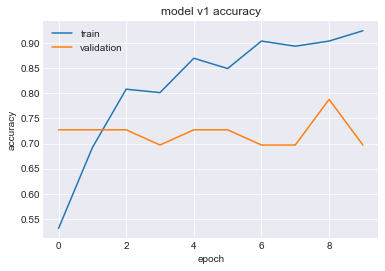

In [288]:
plt.style.use('seaborn-darkgrid')

plt.plot(history.history['accuracy'])     #gives you train accuracy per epoch
plt.plot(history.history['val_accuracy']) #gives you val accuracy per epoch

plt.title(f"model {model_version} accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.savefig(f"model_figures/model_{model_version}_train_accuracy.png")

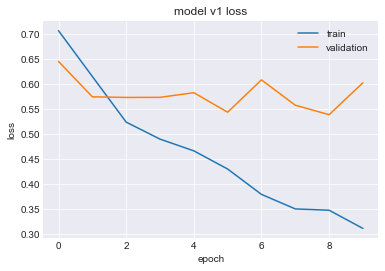

In [287]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title(f"model {model_version} loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig(f"model_figures/model_{model_version}_train_loss.png")

### Accuracy on Test Set

In [222]:
# #when entire test videos were fed into model (w/ constrained number of frames)
# print(f"Accuracy on Test Set for model {model_version}: ",  metrics.accuracy_score(y_true, y_pred))
# print(f"Error on Test Set for model {model_version}   : ", 1 - metrics.accuracy_score(y_true, y_pred))

Accuracy on Test Set for model v1:  0.7073170731707317
Error on Test Set for model v1   :  0.29268292682926833


In [234]:
#when only (occurence + random irrelevant) clips associated with test videos were fed into model (w/ constrained number of frames)
print(f"Accuracy on Test Set for model {model_version}: ",  metrics.accuracy_score(y_true, y_pred))
print(f"Error on Test Set for model {model_version}   : ", 1 - metrics.accuracy_score(y_true, y_pred))

Accuracy on Test Set for model v1:  0.7560975609756098
Error on Test Set for model v1   :  0.24390243902439024


Notes:
- Accuracy is ~70 %, which is lower than the accuracy reported on the test set when we ran the run_experiment() function. This may be because in getting `test_classications`, we fed the entire video into our model, and only extracted `MAX_SEQ_LENGTH` # of frames, which may have skipped over whale content. Should we actually be passing in the video clips + getting our relevant clips from there, or should we be passing in full length videos (although since we constrain the number of frames extracted, we risk the possibility of skipping over frames that contain the whale encounter)?  


- For now (Feb 27 2022), I am feeding occurence/irrelevant CLIPS into model + getting predictions from there, rather than feeding entire videos (40 frames may be too restricting, and not sure how to address this for real world applications)

### Precision - Recall - F1

In [317]:
precision, recall, f1, support =  metrics.precision_recall_fscore_support(y_true, y_pred)

print('----- metrics for classes [0 1] -----')
print('precision:', precision)
print('recall:   ', recall) 
print('f1 score: ', f1)
print('support:  ', support)

----- metrics for classes [0 1] -----
precision: [0.77777778 0.73913043]
recall:    [0.7        0.80952381]
f1 score:  [0.73684211 0.77272727]
support:   [20 21]


Understanding Precision + Recall:
- `Precision`: $\frac{TP}{TP + FP}$
    - "What proportion of positive identifications are correct" 
    - Accuracy focused
    - the ability of a classifier to avoid labeling an actual negative as positive
    - `high precision --> doesn't generate many false positives`
    

    
- `Recall` : $\frac{TP}{TP + FN}$
    - "What proportion of actual positives were identified correctly?"
    - Coverage focused
    - the ability of a classifier to find all the positive samples
    - `high recall --> our classifier is good at finding all the positive samples (not very many FN's)`

- `F1 Score`:  2 * $\frac{TP}{TP + FN}$
    - a weighted harmonic mean of the precision + recall
    - conveys the balance b/w precision and recall
    - useful when working with imbalanced datasets
    - `a high F1 score means your model predicts your classes equally as well`
    - a low F1 score means your model is better at predicting one class over the other

### Confusion Matrix

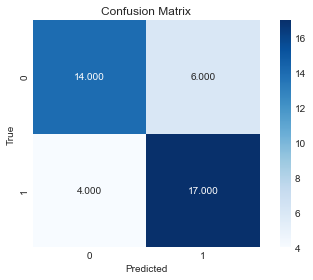

In [290]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.savefig(f"model_figures/model_{model_version}_confusion_matrix")

Interpretation: 
- Model v1 is pretty balanced at correctly predicting each class (slight bias towards predicting videos as relevant). Predicts that actual non-relevant videos are relevant more often than the other way around (predicting actual relevant videos to be nonrelevant)

### Examining + Visualizing Which Videos Were Incorrectly Classified

In [278]:
for index, row in incorrect_classifications.iterrows():
    test_video = row['video']
    
    #display info about video 
    print(f"Test video path: {test_video}")
    print(f"True Label: {row['true']}  Pred Label: {row['pred']}")

    #print an interpretation of classification results
    if (row['true'] == 0) and (row['pred'] == 1):
        print('Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)\n')
    elif (row['true'] == 1) and (row['pred'] == 0):
        print('Interpretation: Model predicted video to be irrelevant but video is actually relevant (does have humpback whales)\n')

    #get + display the prediction probabilities
    test_frames, class_probabilities = sequence_prediction(test_video, video_folder="video_clips", silent=True)

    # print(test_frames.shape)
    # print(test_frames[1:MAX_SEQ_LENGTH].shape)
    # print(np.squeeze(test_frames, axis=0).shape)

    # display video as gif of frames (note that we get rid of the None dimension in test_frames
    # by doing starting at index 1, since we modified the sequence_prediction function to work with our multiple clips from one video)
    test_frames_squeezed = np.squeeze(test_frames, axis=0) #to get rid of the extra None dimension and bring frames back to orig dims
    to_gif(test_frames_squeezed[:MAX_SEQ_LENGTH], video_name = test_video.split('.mp4')[0], saveto_path= 'model_v1_misclassified_gifs/')



Test video path: video_0115.mp4
True Label: 0  Pred Label: 1
Interpretation: Model predicted video to be relevant but video is actually irrelevant (no humpback whales)



----
### Notes + Observations on Misclassifications:

1. Model v1
    - Looking at our GIFS (`model_v1_misclassified_gifs/`), our model has a hard time distinguishing whether a video is relevant or not when footage is underwater or in some sort of marine/aquatic setting, and may contain other types of marine life that aren't necessarily humpback whales (ex. dolphins, or other types of whales). Also, in the cases where there are humpback whales in the video clip, but the model says there isn't, the resolution of these clips is not very good, or it may be hard to see the humpback whales, even for us humans (ex. `video_0695.gif`), as they may blend in with the background or be really far away.

----

### To Do / Next Steps: 
- need to properly pass in train set (with this architecture, we get the validation set from our train set. Currently, our train/val sets are separate)
- figure out what the mmco unref error was when we were trying to load frames from valid set
- plot the performance of our network + use visuals to assess before deciding what to improve
- look for parts to play around with/improve in this architecture; what other architectures should we try considering?
    - can our classifier distinguish between different species of whales (ex. will it generate right prediction for a video of a blue whale (nonrelevant) vs a video with a humpback whale (relevant)) ?
    - can we get accuracy higher than 75% (ideally, we'd like accuracy above 80/90)?

# Other Resources to Read:
- https://towardsdatascience.com/introduction-to-video-classification-6c6acbc57356 (for ideas on other strategies to try)
- https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5 